# Análisis de Datos de Calidad del Aire usando Elasticsearch y Python

Este proyecto tiene como objetivo **explorar, procesar y analizar un conjunto de datos que contiene más de un millón de registros** sobre la calidad del aire, recopilados durante el año 2020. La fuente de los datos incluye mediciones horarias de diversos compuestos químicos atmosféricos como:

- Monóxido de carbono (`CO`)
- Óxidos de nitrógeno (`NO`, `NO2`)
- Ozono (`O3`)
- Dióxido de azufre (`SO2`)
- Partículas suspendidas (`PM`, `PM10`, `PM2.5`)

Cada registro está asociado a una **estación de monitoreo** e incluye información detallada como la **fecha y hora de la lectura**, el **ID de la estación** y el **ID de la red** a la que pertenece.

El análisis se realiza utilizando **Python** y **Elasticsearch**, aprovechando su capacidad para manejar grandes volúmenes de datos y realizar consultas complejas de forma eficiente. La información extraída permitirá:

- Identificar patrones de contaminación
- Comparar niveles entre estaciones o periodos de tiempo
- Establecer bases para estudios relacionados con la calidad del aire y su impacto en la salud pública

Este notebook está estructurado en secciones que cubren desde la **conexión con Elasticsearch**, **carga y transformación de datos**, hasta el **análisis exploratorio** y la **visualización de resultados** obtenidos.

> ⚙️ *Tecnologías utilizadas:* Python, Elasticsearch, Pandas


In [1]:
import pandas as pd
from elasticsearch import Elasticsearch, helpers
import json
import matplotlib.pyplot as plt

## Transformación de los Datos

En esta sección, se detallan los pasos seguidos para transformar el conjunto de datos original (en formato `.csv`) a un formato adecuado para ser cargado en Elasticsearch. Este proceso incluyó la limpieza de los datos, la conversión de columnas clave y la preparación de los registros en formato `.jsonl`, compatible con el _Bulk API_ de Elasticsearch.

1. **Carga de CSV y Limpieza de datos**: Se realizaron transformaciones en columnas específicas (como la conversión de fechas y pivot de columnas a compuestos individuales).
2. **Conversión a formato JSONL**: Finalmente, los registros fueron convertidos a formato `.jsonl`, donde cada línea representa un objeto JSON, facilitando la carga masiva a Elasticsearch.

A continuación, se muestra el código utilizado para realizar estas transformaciones:


1. **Cargamos el conjunto de datos `.csv` y pivotamos una columna en varias columnas para tener mediciones completas por fecha**

In [2]:
# 1. Cargar los datos
df = pd.read_csv('./Datos2020.csv')

# Limpiar espacios en nombres de columnas
df.columns = df.columns.str.strip()

# 2. Pivotear los valores de una sola columna en columnas individuales
df_pivot = df.pivot_table(
    index=['red_id','estacion_id','fc_lectura','hora_lectura',],   # usamos 'fc_lectura' como fecha
    columns='contaminante_id',
    values='lectura',                      # esta es la columna correcta
    aggfunc='mean'
).reset_index()

df_pivot.columns.name = None

# 3. Rellenar faltantes
df_pivot = df_pivot.fillna(0)

# 4. Guardar en CSV para revisar
df_pivot.to_csv('./DatosAireTransformados.csv', index=False)

2. **Convertimos nuestro recien creado archivo `DatosAireTransformados.csv` en un archivo en formato `.jsonl` para poder insertarlo utilizando _Bulk_**

In [3]:
# Cargar el archivo CSV
df = pd.read_csv('./DatosAireTransformados.csv')

# Convertir el DataFrame a formato JSON lines
df.to_json('./datos_aire.jsonl', orient='records', lines=True, force_ascii=False)

## Conexión con Elasticsearch

Una vez transformados los datos a formato `.jsonl`, el siguiente paso es establecer la conexión con el servidor de **Elasticsearch** para cargar los registros en el índice correspondiente.

Para ello, se utilizará la librería oficial de **Elasticsearch para Python**, la cual permite interactuar con el clúster de Elasticsearch de manera eficiente. En esta sección, se configurará la conexión a un clúster local de Elasticsearch y se verificará su disponibilidad.

El proceso incluye:

1. **Conexión al servidor**: Se especifica la URL del clúster de Elasticsearch.
2. **Verificación de conexión**: Se realiza una comprobación para asegurarse de que la conexión fue exitosa.

A continuación se muestra el código utilizado para realizar esta conexión.


1. **Conexión con el servidor de ElasticSearch**

Para mantener el código organizado y reutilizable, se define una clase llamada `ElasticSearchProvider` que encapsula la conexión al clúster de Elasticsearch. Esta clase permite establecer la conexión de forma segura utilizando el contexto `with`, asegurando también el cierre adecuado de la sesión.

In [2]:
class ElasticSearchProvider:
    def __init__(self):
        self.host = "http://localhost:9200"
        self.index = "air-metrics"
        self.index_type = "_doc"
        self.connection = Elasticsearch(self.host)

    def __enter__(self):
        try:
            self.connection = Elasticsearch(self.host)
            return self
        except Exception as e:
            return{
                "StatusCode": 500,
                "body":json.dumps({
                    "message": str(e)
                })
            }

    def __exit__(self, exception_type, exception_val, exception_traceback):
        self.connection.close()

2. **Prueba de Conexión**

Hacemos una prueba para ver si el servidor responde correctamente

In [4]:
with ElasticSearchProvider() as es_provider:
    print("Conectando a Elasticsearch...")
    if es_provider.connection.ping():
        info = es_provider.connection.info()
        print("Se conectó correctamente a servidor")
        print("Informacion del cluster:")
        print(info)
    else:
        print("No se pudo conectar con Elasticsearch")


Conectando a Elasticsearch...
Se conectó correctamente a servidor
Informacion del cluster:
{'name': 'DESKTOP-PC1PL58', 'cluster_name': 'elasticsearch', 'cluster_uuid': 's6j-Pdu9Th-DkYDtJyWxYg', 'version': {'number': '8.17.1', 'build_flavor': 'default', 'build_type': 'zip', 'build_hash': 'd4b391d925c31d262eb767b8b2db8f398103f909', 'build_date': '2025-01-10T10:08:26.972230187Z', 'build_snapshot': False, 'lucene_version': '9.12.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


## Inserción de Datos al Índice en Elasticsearch

Una vez establecida la conexión con el servidor de Elasticsearch, el siguiente paso es **insertar los datos transformados** en el índice `air-metrics`.

El archivo previamente generado en formato `.jsonl` contiene más de un millón de registros con mediciones horarias de contaminantes del aire. Para insertar estos datos de forma eficiente, se utilizará la función `helpers.bulk()` proporcionada por la librería oficial de Elasticsearch para Python.

Este proceso puede tardar varios minutos dependiendo del tamaño del archivo y del rendimiento del servidor.


In [23]:
class ElasticSearchProvider:
    def __init__(self):
        self.host = "http://localhost:9200"
        self.index = "air-metrics"
        self.index_type = "_doc"
        self.connection = Elasticsearch(self.host)

    def __enter__(self):
        try:
            self.connection = Elasticsearch(self.host)
            return self
        except Exception as e:
            return{
                "StatusCode": 500,
                "body":json.dumps({
                    "message": str(e)
                })
            }

    def __exit__(self, exception_type, exception_val, exception_traceback):
        self.connection.close()
    
    def load_json_files(self, file_path):
        with open(file_path,'r',encoding="utf-8") as file:
            documents = []
            for line in file:
                try:
                    doc = json.loads(line.strip())
                    documents.append({"_index":self.index, "_source": doc})
                except json.JSONDecodeError as e:
                    print(f"Error: {e}")
                
            if documents:
                helpers.bulk(self.connection, documents)
                print(f" {len(documents)} documents inserted in {self.index}")

## Ejecución de la Inserción de Datos

Con la clase `ElasticSearchProvider` actualizada y el método `load_json_files` definido, ahora se procede a ejecutar la inserción de datos en el índice `air-metrics`.

El archivo `aire_2020.jsonl` contiene más de un millón de registros que serán insertados en bloques mediante la función `helpers.bulk()` para optimizar el rendimiento de la operación.

>**Nota:** Este proceso puede tomar varios minutos dependiendo del tamaño del archivo y la capacidad del servidor Elasticsearch.


In [ ]:
file_path = './datos_aire.jsonl'

try:
    with ElasticSearchProvider() as es:
        es.load_json_files(file_path)
        print('Archivo JSON cargado exitosamente:', file_path)
except Exception as error:
    print('Error al cargar el archivo:', error)

 1091288 documents inserted in air-metrics
✅ Archivo JSON cargado exitosamente: ./datos_aire.jsonl


## Consultas al Índice `air-metrics` en Elasticsearch

Una vez completada la inserción de los datos, se procede a realizar una serie de **15 consultas** al índice `air-metrics`. Estas consultas tienen como objetivo:

- Validar la integridad y estructura de los datos insertados.
- Obtener estadísticas y distribuciones sobre los diferentes contaminantes.
- Identificar patrones, valores atípicos y tendencias temporales en las mediciones del aire.

Las consultas se realizarán utilizando el cliente oficial de Elasticsearch en Python y estarán centradas en campos clave como:

- **Fechas de lectura (`fc_lectura`)**
- **Contaminantes (`CO`, `NO`, `NO2`, `O3`, `PM`, `PM10`, `PM25`, `SO2`)**
- **Horas de medición (`hora_lectura`)**
- **Estaciones (`estacion_id`) y redes (`red_id`)**

Cada consulta incluirá:
- Una descripción del objetivo.
- El cuerpo de la consulta (query).
- Los resultados obtenidos y, si aplica, una breve interpretación.

> *Estas consultas ayudarán a extraer información significativa del conjunto de datos y demostrarán el poder de búsqueda y agregación de Elasticsearch aplicado a datos ambientales.*


### Consulta 1: Cual es el total de documentos en el indice

In [ ]:
with ElasticSearchProvider() as es:
    query = {
        "query": {
            "match_all": {}
        }
    }

    result = es.connection.count(index=es.index, body=query)
    print("Total de documentos en el índice:", result['count'])

### Consulta 2: Numero de estaciones de monitoreo

In [11]:
with ElasticSearchProvider() as es:
    query = {
        "aggs":{
            "estaciones":{
                "cardinality":{
                    "field":"estacion_id"
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)
    total_estaciones = result['aggregations']['estaciones']['value']
    print("Total de estaciones:", total_estaciones)


Total de estaciones: 124


### Consulta 3: Numero de redes de monitoreo

In [ ]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "redes_monitoreo": {
                "terms": {
                    "field": "red_id",
                    "size": 100
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    redes = []
    for bucket in result['aggregations']['redes_monitoreo']['buckets']:
        redes.append(bucket['key'])

    print("Número de redes de monitoreo disponibles en el índice:")
    print(len(redes))


### Consulta 4: Numero de estaciones de cada red de monitoreo

In [ ]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "red_id": {
                "terms": {
                    "field": "red_id",
                    "size": 50
                },
                "aggs": {
                    "estacion_id": {
                        "cardinality": {
                            "field": "estacion_id"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    redes = []
    num_estaciones = []
    for bucket in result['aggregations']['red_id']['buckets']:
        redes.append(bucket['key'])
        num_estaciones.append(bucket['estacion_id']['value'])

    df = pd.DataFrame({
        "Red de Monitoreo": redes,
        "Número de Estaciones": num_estaciones
    })

    print("Número de estaciones por red de monitoreo:")
    print(df)

### Consulta 5: Numero de registros por estacion

In [ ]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_estacion": {
                "terms": {
                    "field": "estacion_id",
                    "size": 20
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    estaciones = []
    conteos = []
    for bucket in result['aggregations']['por_estacion']['buckets']:
        estaciones.append(bucket['key'])
        conteos.append(bucket['doc_count'])

    df = pd.DataFrame({
        "Estación": estaciones,
        "Registros": conteos
    })

    print("Número de registros por estación:")
    print(df)


### Consulta 6: Promedio del valor de PM25 organizado por meses

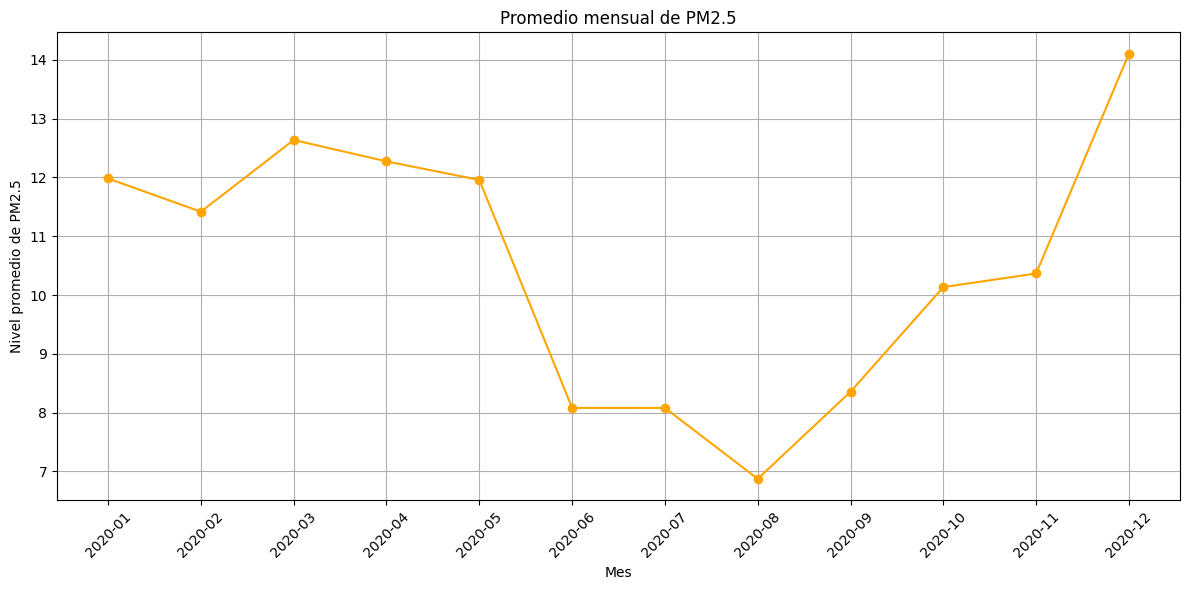

In [9]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "promedio_pm25_mensual": {
                "date_histogram": {
                    "field": "fc_lectura",
                    "calendar_interval": "month",
                    "format": "yyyy-MM"
                },
                "aggs": {
                    "pm25_avg": {
                        "avg": {
                            "field": "PM25"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    # Extraer datos
    meses = []
    promedios = []
    for bucket in result['aggregations']['promedio_pm25_mensual']['buckets']:
        meses.append(bucket['key_as_string'])
        promedios.append(bucket['pm25_avg']['value'])

    # Crear DataFrame
    df = pd.DataFrame({
        "Mes": meses,
        "Promedio_PM25": promedios
    })

    # Graficar
    plt.figure(figsize=(12,6))
    plt.plot(df["Mes"], df["Promedio_PM25"], marker='o', color='orange')
    plt.xticks(rotation=45)
    plt.title("Promedio mensual de PM2.5")
    plt.xlabel("Mes")
    plt.ylabel("Nivel promedio de PM2.5")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Consulta 7: Dia con mayor concentración de PM10

In [10]:
with ElasticSearchProvider() as es:
    query = {
        "size": 1,
        "sort": [{"PM10": "desc"}]
    }

    result = es.connection.search(index=es.index, body=query)

    doc = result['hits']['hits'][0]['_source']
    print("Día con mayor concentración de PM10:")
    print(f"Fecha: {doc['fc_lectura']}, Hora: {doc['hora_lectura']}, PM10: {doc['PM10']}")


Día con mayor concentración de PM10:
Fecha: 2020-12-31, Hora: 24, PM10: 837.0


### Consulta 8: Promedio diario de O3

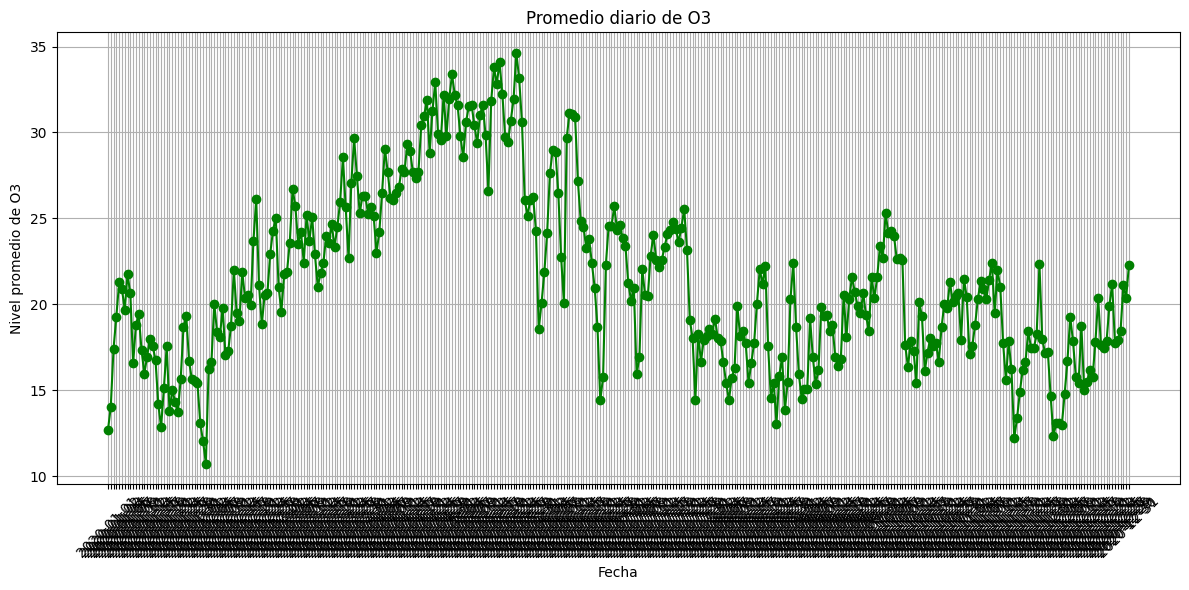

In [11]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "o3_diario": {
                "date_histogram": {
                    "field": "fc_lectura",
                    "calendar_interval": "day"
                },
                "aggs": {
                    "avg_o3": {
                        "avg": {
                            "field": "O3"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    fechas = []
    promedios = []
    for bucket in result['aggregations']['o3_diario']['buckets']:
        fechas.append(bucket['key_as_string'])
        promedios.append(bucket['avg_o3']['value'])

    df = pd.DataFrame({"Fecha": fechas, "Promedio_O3": promedios})

    plt.figure(figsize=(12,6))
    plt.plot(df["Fecha"], df["Promedio_O3"], marker='o', color='green')
    plt.xticks(rotation=45)
    plt.title("Promedio diario de O3")
    plt.xlabel("Fecha")
    plt.ylabel("Nivel promedio de O3")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Consulta 9: Comparación de NO2 entre estaciones

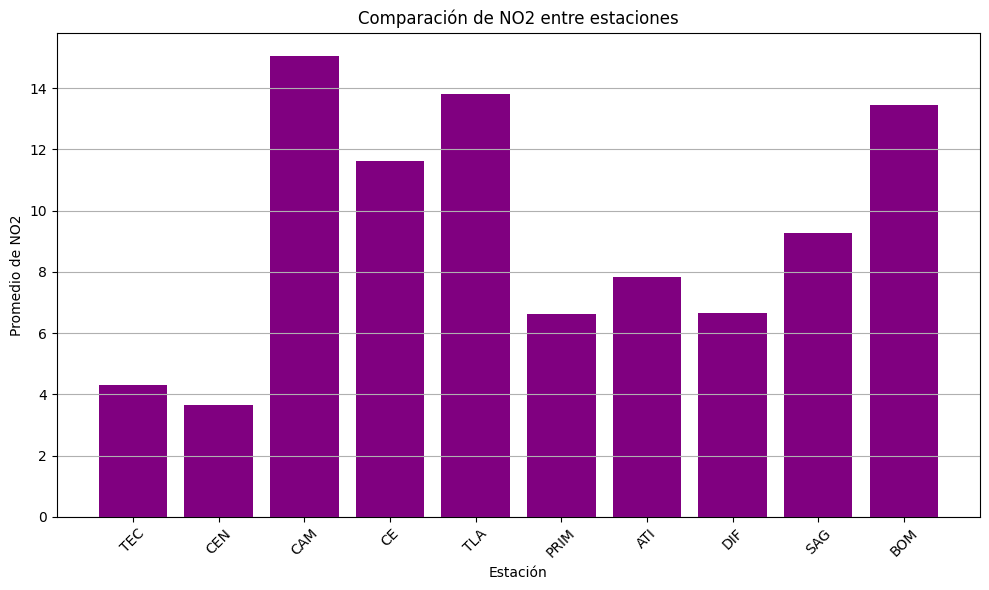

In [12]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_estacion": {
                "terms": {
                    "field": "estacion_id",
                    "size": 10
                },
                "aggs": {
                    "avg_no2": {
                        "avg": {
                            "field": "NO2"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    estaciones = []
    promedios = []
    for bucket in result['aggregations']['por_estacion']['buckets']:
        estaciones.append(bucket['key'])
        promedios.append(bucket['avg_no2']['value'])

    df = pd.DataFrame({"Estación": estaciones, "Promedio_NO2": promedios})

    plt.figure(figsize=(10,6))
    plt.bar(df["Estación"], df["Promedio_NO2"], color='purple')
    plt.title("Comparación de NO2 entre estaciones")
    plt.xlabel("Estación")
    plt.ylabel("Promedio de NO2")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


### Consulta 10: Top 5 dias con mayor nivel de PM10 + PM25

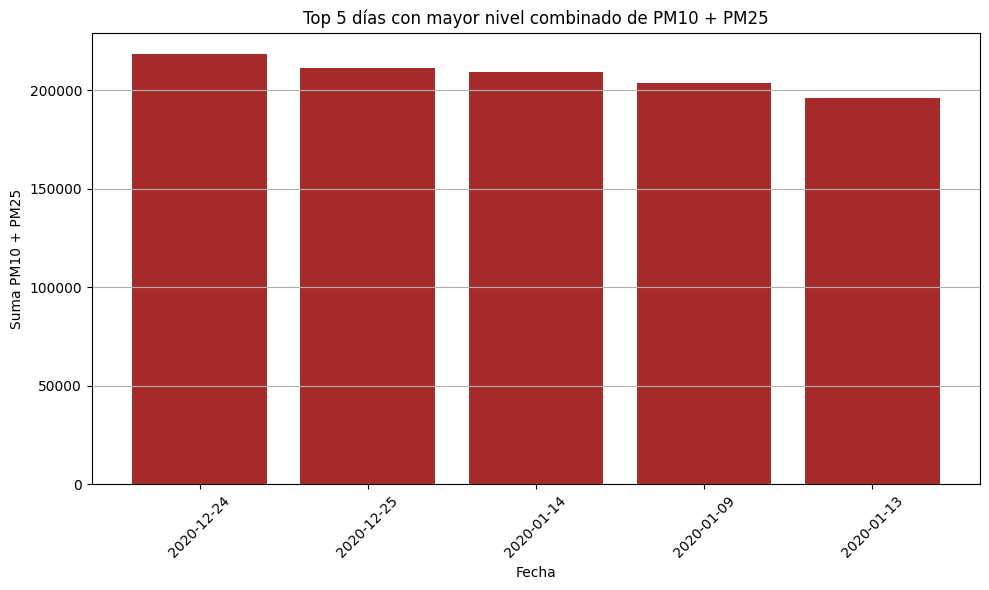

In [13]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_dia": {
                "date_histogram": {
                    "field": "fc_lectura",
                    "calendar_interval": "day"
                },
                "aggs": {
                    "suma_pm": {
                        "sum": {
                            "script": {
                                "source": "doc['PM10'].value + doc['PM25'].value",
                                "lang": "painless"
                            }
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    fechas = []
    sumas = []
    for bucket in result['aggregations']['por_dia']['buckets']:
        fechas.append(bucket['key_as_string'])
        sumas.append(bucket['suma_pm']['value'])

    df = pd.DataFrame({"Fecha": fechas, "Suma_PM10_PM25": sumas})
    df = df.sort_values(by="Suma_PM10_PM25", ascending=False).head(5)

    plt.figure(figsize=(10,6))
    plt.bar(df["Fecha"], df["Suma_PM10_PM25"], color='brown')
    plt.title("Top 5 días con mayor nivel combinado de PM10 + PM25")
    plt.xlabel("Fecha")
    plt.ylabel("Suma PM10 + PM25")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


### Consulta 11: Media de contaminantes por red de monitoreo

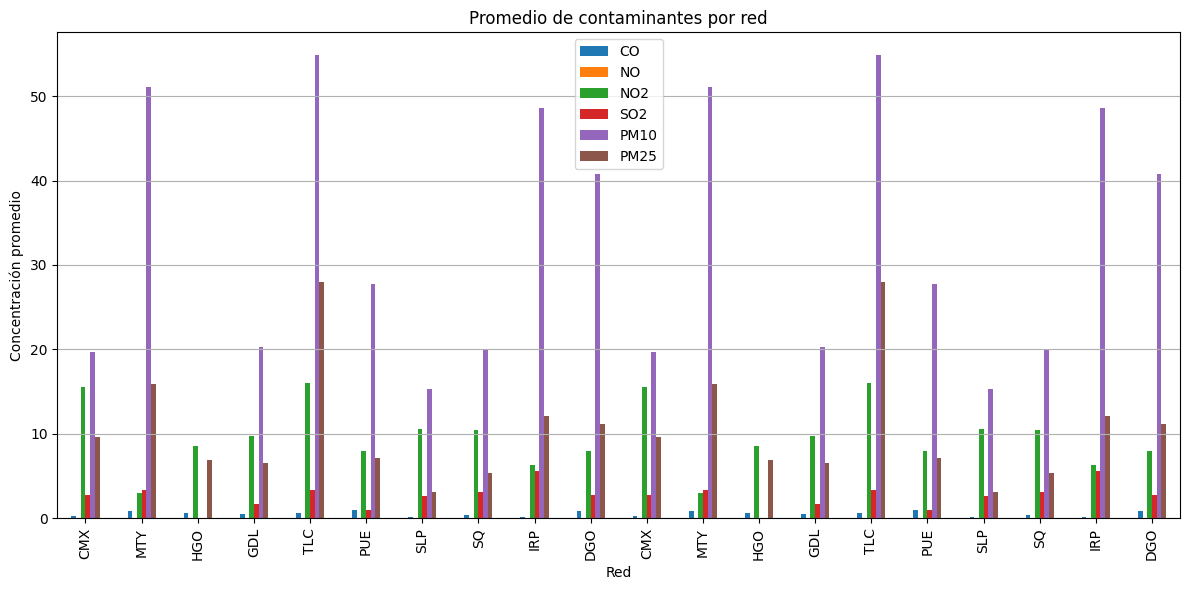

In [20]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_red": {
                "terms": {
                    "field": "red_id",
                    "size": 10
                },
                "aggs": {
                    "avg_co": {"avg": {"field": "CO"}},
                    "avg_no": {"avg": {"field": "NO"}},
                    "avg_no2": {"avg": {"field": "NO2"}},
                    "avg_so2": {"avg": {"field": "SO2"}},
                    "avg_pm10": {"avg": {"field": "PM10"}},
                    "avg_pm25": {"avg": {"field": "PM25"}},
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    red = []
    co = []
    no = []
    no2 = []
    so2 = []
    pm10 = []
    pm25 = []
    for bucket in result['aggregations']['por_red']['buckets']:
        red.append(bucket['key'])
        co.append(bucket['avg_co']['value'])
        no.append(bucket['avg_no']['value'])
        no2.append(bucket['avg_no2']['value'])
        so2.append(bucket['avg_so2']['value'])
        pm10.append(bucket['avg_pm10']['value'])
        pm25.append(bucket['avg_pm25']['value'])

    for bucket in result['aggregations']['por_red']['buckets']:
        red.append(bucket['key'])
        co.append(bucket['avg_co']['value'])
        no.append(bucket['avg_no']['value'])
        no2.append(bucket['avg_no2']['value'])
        so2.append(bucket['avg_so2']['value'])
        pm10.append(bucket['avg_pm10']['value'])
        pm25.append(bucket['avg_pm25']['value'])

    df = pd.DataFrame({
        "Red": red,
        "CO": co,
        "NO": no,
        "NO2": no2,
        "SO2": so2,
        "PM10": pm10,
        "PM25": pm25
    })

    df.set_index("Red").plot(kind='bar', figsize=(12,6))
    plt.title("Promedio de contaminantes por red")
    plt.ylabel("Concentración promedio")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


### Consulta 12: Dia con mayor promedio total de contaminantes combinados

In [24]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_dia": {
                "date_histogram": {
                    "field": "fc_lectura",
                    "calendar_interval": "day"
                },
                "aggs": {
                    "avg_total": {
                        "avg": {
                            "script": {
                                "source": """
                                    (doc['CO'].value + doc['NO'].value + doc['NO2'].value + doc['O3'].value +
                                     doc['PM'].value + doc['PM10'].value + doc['PM25'].value + doc['SO2'].value) / 8
                                """,
                                "lang": "painless"
                            }
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    fechas = []
    promedios = []
    for bucket in result['aggregations']['por_dia']['buckets']:
        fechas.append(bucket['key_as_string'])
        promedios.append(bucket['avg_total']['value'])

    df = pd.DataFrame({
        "Fecha": fechas,
        "Promedio_Contaminantes": promedios
    })

    df_max = df.sort_values(by="Promedio_Contaminantes", ascending=False).head(1)
    display(df_max)


,Fecha,Promedio_Contaminantes
358,2020-12-24,14.193641


### Consulta 13: Evolucion semanal del promedio de PM10

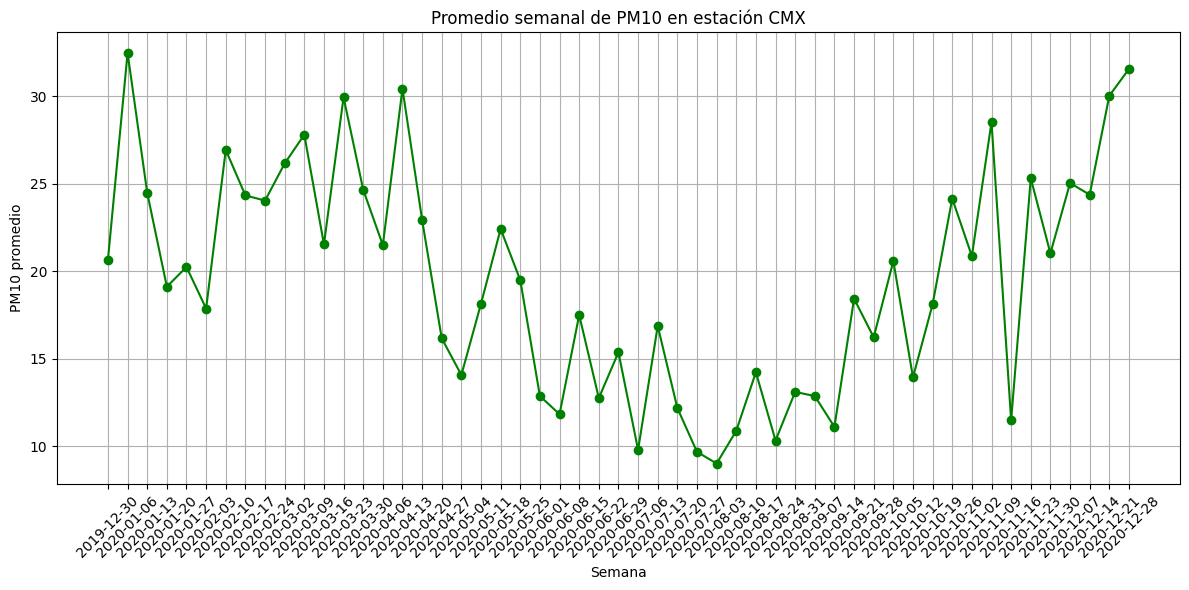

In [28]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "estacion_uno": {
                "filter": {
                    "term": {
                        "red_id": "CMX"
                    }
                },
                "aggs": {
                    "por_semana": {
                        "date_histogram": {
                            "field": "fc_lectura",
                            "calendar_interval": "week",
                            "format": "yyyy-MM-dd"
                        },
                        "aggs": {
                            "avg_pm10": {
                                "avg": {
                                    "field": "PM10"
                                }
                            }
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    semanas = []
    promedios = []
    # Acceder a los buckets correctamente dentro de la agregación anidada
    for bucket in result['aggregations']['estacion_uno']['por_semana']['buckets']:
        semanas.append(bucket['key_as_string'])
        promedios.append(bucket['avg_pm10']['value'])

    df = pd.DataFrame({
        "Semana": semanas,
        "Promedio_PM10": promedios
    })

    plt.figure(figsize=(12,6))
    plt.plot(df["Semana"], df["Promedio_PM10"], marker='o', color='green')
    plt.xticks(rotation=45)
    plt.title("Promedio semanal de PM10 en estación CMX")
    plt.xlabel("Semana")
    plt.ylabel("PM10 promedio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Consulta 14: Registros con niveles de O3 superiores a 180

In [31]:
with ElasticSearchProvider() as es:
    query = {
        "query": {
            "range": {
                "O3": {
                    "gte": 180
                }
            }
        },
        "size": 1000,
        "_source": ["fc_lectura", "hora_lectura", "estacion_id", "O3"]
    }

    result = es.connection.search(index=es.index, body=query)

    fechas, horas, estaciones, niveles = [], [], [], []
    for hit in result['hits']['hits']:
        doc = hit['_source']
        fechas.append(doc['fc_lectura'])
        horas.append(doc['hora_lectura'])
        estaciones.append(doc['estacion_id'])
        niveles.append(doc['O3'])

    df = pd.DataFrame({
        "Fecha": fechas,
        "Hora": horas,
        "Estación": estaciones,
        "O3": niveles
    })

    display(df.head(10))


,Fecha,Hora,Estación,O3


### Consulta 15: Porcentaje de los datos por red de monitoreo

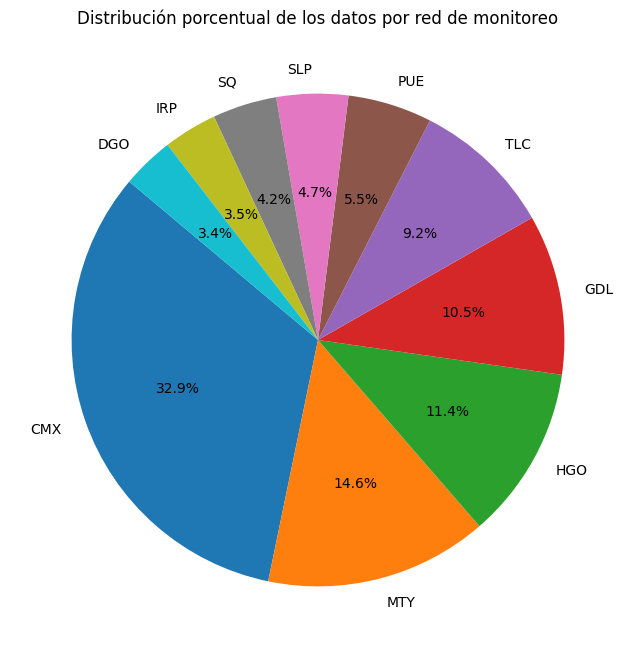

In [39]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "redes_monitoreo": {
                "terms": {
                    "field": "red_id",
                    "size": 10
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    redes = []
    porcentajes = []
    total_docs = result['hits']['total']['value']
    
    for bucket in result['aggregations']['redes_monitoreo']['buckets']:
        red = bucket['key']
        count = bucket['doc_count']
        porcentaje = (count / total_docs) * 100
        redes.append(red)
        porcentajes.append(porcentaje)

    # Crear DataFrame para fácil visualización
    df = pd.DataFrame({
        "Red de Monitoreo": redes,
        "Porcentaje": porcentajes
    })

    # Graficar con un gráfico de pastel
    plt.figure(figsize=(8, 8))
    plt.pie(df["Porcentaje"], labels=df["Red de Monitoreo"], autopct='%1.1f%%', startangle=140)
    plt.title("Distribución porcentual de los datos por red de monitoreo")
    plt.show()


### Consulta 16: Concentración promedio de PM25 por hora

In [ ]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "promedio_por_hora": {
                "terms": {
                    "field": "hora_lectura",
                    "size": 24,
                    "order": {"_key": "asc"}
                },
                "aggs": {
                    "pm25_avg": {
                        "avg": {
                            "field": "PM25"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    horas = []
    promedios = []
    for bucket in result['aggregations']['promedio_por_hora']['buckets']:
        horas.append(bucket['key'])
        promedios.append(bucket['pm25_avg']['value'])

    df = pd.DataFrame({
        "Hora": horas,
        "Promedio_PM25": promedios
    })

    plt.figure(figsize=(10,5))
    plt.plot(df["Hora"], df["Promedio_PM25"], marker='o', color='brown')
    plt.xticks(df["Hora"])
    plt.title("Promedio de PM2.5 por hora del día")
    plt.xlabel("Hora")
    plt.ylabel("Nivel promedio de PM2.5")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Consulta 16: Top 10 de estaciones con mayores niveles de SO2 promedio

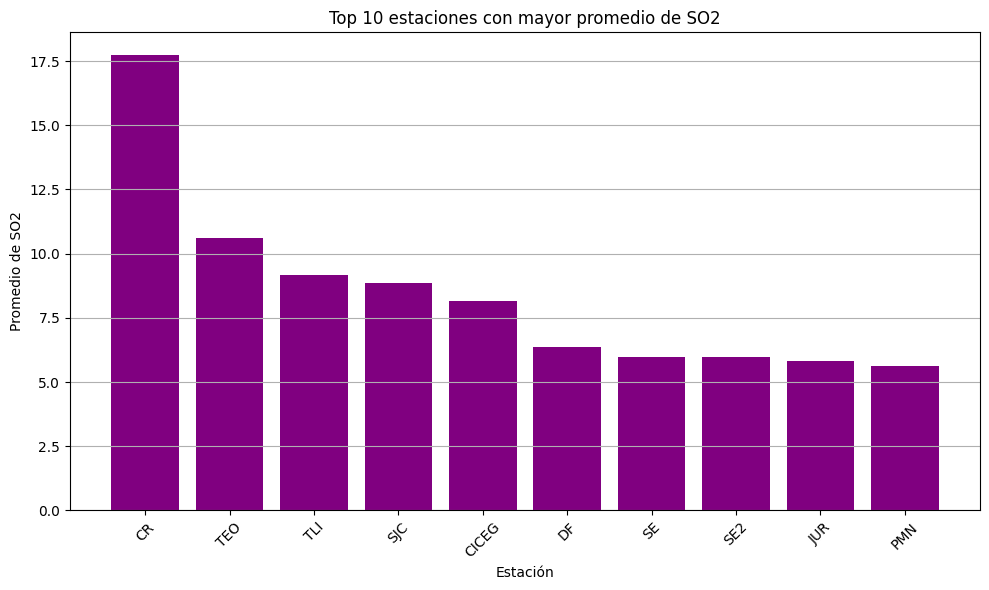

In [7]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs":{
            "por_estacion":{
                "terms":{
                    "field":"estacion_id",
                    "size":124
                },
                "aggs":{
                    "promedio_so2":{
                        "avg":{
                            "field":"SO2"
                        }
                    }
                }
                
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)
    estaciones = []
    promedios = []

    for bucket in result['aggregations']['por_estacion']['buckets']:
        estaciones.append(bucket['key'])
        promedios.append(bucket['promedio_so2']['value'])

    df = pd.DataFrame({
        "Estación": estaciones,
        "Promedio_SO2": promedios
    })

    df = df.sort_values(by="Promedio_SO2", ascending=False).head(10)
    plt.figure(figsize=(10,6))
    plt.bar(df["Estación"], df["Promedio_SO2"], color='purple')
    plt.title("Top 10 estaciones con mayor promedio de SO2")
    plt.xlabel("Estación")
    plt.ylabel("Promedio de SO2")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()